### Fashion-MNIST Clothing Photograph Dataset
The Fashion-MNIST dataset is proposed as a more challenging replacement dataset for the MNIST dataset.

It is a dataset comprised of 60,000 small square 28×28 pixel grayscale images of items of 10 types of clothing, such as shoes, t-shirts, dresses, and more.

Keras provides access to the Fashion-MNIST dataset via the fashion_mnist.load_dataset() function. It returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset.

In [1]:
import matplotlib.pyplot as plt

In [2]:
# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


The images are grayscale with a black background (0 pixel value) and the items of clothing are in white ( pixel values near 255). This means if the images were plotted, they would be mostly black with a white item of clothing in the middle.

We can plot some of the images from the training dataset using the matplotlib library with the imshow() function and specify the color map via the ‘cmap‘ argument as ‘gray‘ to show the pixel values correctly.

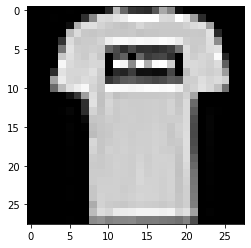

In [3]:
# plot raw pixel data
plt.imshow(trainX[1], cmap='gray')

Alternately, the images are easier to review when we reverse the colors and plot the background as white and the clothing in black.

#### They are easier to view as most of the image is now white with the area of interest in black. This #### can be achieved using a reverse grayscale color map, as follows

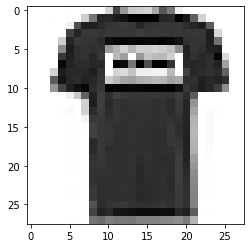

In [4]:
# plot raw pixel data
plt.imshow(trainX[1], cmap='gray_r')

### The example below plots the first 100 images from the training dataset in a 10 by 10 square.

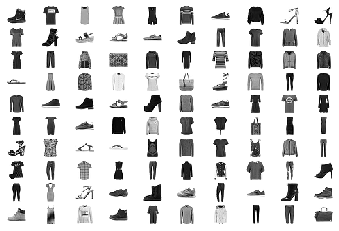

In [5]:
# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
from matplotlib import pyplot

# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

# plot images from the training dataset
for i in range(100):
    # define subplot
    pyplot.subplot(10, 10, 1 + i)
    
    # turn off axis
    pyplot.axis('off')
    
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap='gray_r')

pyplot.show()

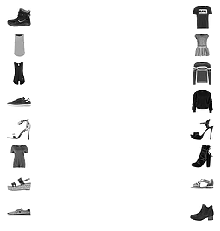

In [6]:
for i in range(16):
    # define subplot
    pyplot.subplot(8, 2, 1 + i)
    
    # turn off axis
    pyplot.axis('off')
    
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap='gray_r')

pyplot.show()

We will use the images in the training dataset as the basis for training a Generative Adversarial Network.

### Specifically, the generator model will learn how to generate new plausible items of clothing  and using a discriminator that will try to distinguish between real images from the Fashion MNIST training dataset and new images output by the generator model.

## Unconditional GAN for Fashion-MNIST

In this section, we will develop an unconditional GAN for the Fashion-MNIST dataset.

The first step is to define the models.

The discriminator model takes as input one 28×28 grayscale image and outputs a binary prediction as to whether the image is real (class=1) or fake (class=0). 
It is implemented as a modest convolutional neural network using best practices for GAN design such as using the LeakyReLU activation function with a slope of 0.2, using a 2×2 stride to downsample, and the adam version of stochastic gradient descent with a learning rate of 0.0002 and a momentum of 0.5

The define_discriminator() function below implements this, defining and compiling the discriminator model and returning it. 
The input shape of the image is parameterized as a default function argument in case you want to re-use the function for your own image data later

In [7]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

The generator model takes as input a point in the latent space and outputs a single 28×28 grayscale image. This is achieved by using a fully connected layer to interpret the point in the latent space and provide sufficient activations that can be reshaped into many copies (in this case 128) of a low-resolution version of the output image (e.g. 7×7). This is then upsampled twice, doubling the size and quadrupling the area of the activations each time using transpose convolutional layers. The model uses best practices such as the LeakyReLU activation, a kernel size that is a factor of the stride size, and a hyperbolic tangent (tanh) activation function in the output layer.

The define_generator() function below defines the generator model, but intentionally does not compile it as it is not trained directly, then returns the model. The size of the latent space is parameterized as a function argument

In [8]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    return model

Next, a GAN model can be defined that combines both the generator model and the discriminator model into one larger model. This larger model will be used to train the model weights in the generator, using the output and error calculated by the discriminator model. The discriminator model is trained separately, and as such, the model weights are marked as not trainable in this larger GAN model to ensure that only the weights of the generator model are updated. This change to the trainability of the discriminator weights only has an effect when training the combined GAN model, not when training the discriminator standalone.

This larger GAN model takes as input a point in the latent space, uses the generator model to generate an image which is fed as input to the discriminator model, then is output or classified as real or fake.

The define_gan() function below implements this, taking the already-defined generator and discriminator models as input

In [9]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Now that we have defined the GAN model, we need to train it. But, before we can train the model, we require input data.

The first step is to load and prepare the Fashion MNIST dataset. We only require the images in the training dataset. The images are black and white, therefore we must``` add an additional channel dimension to transform them to be three dimensional, as expected by the convolutional layers of our models. Finally, the pixel values must be scaled to the range [-1,1] to match the output of the generator model.```

The load_real_samples() function below implements this, returning the loaded and scaled Fashion MNIST training dataset ready for modeling.

In [10]:
# load fashion mnist images
def load_real_samples():
    # load dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

We will require one batch (or a half) batch of real images from the dataset each update to the GAN model. A simple way to achieve this is to select a random sample of images from the dataset each time.

The generate_real_samples() function below implements this, taking the prepared dataset as an argument, selecting and returning a random sample of Fashion MNIST images and their corresponding class label for the discriminator, specifically class=1, indicating that they are real images.

In [11]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

Next, we need inputs for the generator model. These are random points from the latent space, specifically Gaussian distributed random variables.

The generate_latent_points() function implements this, taking the size of the latent space as an argument and the number of points required and returning them as a batch of input samples for the generator model.

In [12]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

Next, we need to use the points in the latent space as input to the generator in order to generate new images.

The generate_fake_samples() function below implements this, taking the generator model and size of the latent space as arguments, then generating points in the latent space and using them as input to the generator model. The function returns the generated images and their corresponding class label for the discriminator model, specifically class=0 to indicate they are fake or generated

In [13]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X, y

We are now ready to fit the GAN models.

The model is fit for 100 training epochs, which is arbitrary, as the model begins generating plausible items of clothing after perhaps 20 epochs. A batch size of 128 samples is used, and each training epoch involves 60,000/128, or about 468 batches of real and fake samples and updates to the model.

First, the discriminator model is updated for a half batch of real samples, then a half batch of fake samples, together forming one batch of weight updates. The generator is then updated via the composite gan model. Importantly, the class label is set to 1 or real for the fake samples. This has the effect of updating the generator toward getting better at generating real samples on the next batch.

The train() function below implements this, taking the defined models, dataset, and size of the latent dimension as arguments and parameterizing the number of epochs and batch size with default arguments. The generator model is saved at the end of training.

In [14]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)  
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('generator.h5')

We can then define the size of the latent space, define all three models, and train them on the loaded fashion MNIST dataset

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

### Tying all of this together, the complete example is listed below.

In [15]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
 
# load fashion mnist images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return [X, trainy]
 
# # select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch) # n_epoch = 100, n_batch= 128
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('cgan_generator.h5')
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/468, d1=0.646, d2=0.696 g=0.691
>1, 2/468, d1=0.565, d2=0.701 g=0.686
>1, 3/468, d1=0.512, d2=0.710 g=0.677
>1, 4/468, d1=0.458, d2=0.725 g=0.663
>1, 5/468, d1=0.407, d2=0.750 g=0.641
>1, 6/468, d1=0.365, d2=0.785 g=0.617
>1, 7/468, d1=0.332, d2=0.832 g=0.595
>1, 8/468, d1=0.292, d2=0.868 g=0.584
>1, 9/468, d1=0.279, d2=0.861 g=0.607
>1, 10/468, d1=0.291, d2=0.810 g=0.667
>1, 11/468, d1=0.279, d2=0.713 g=0.772
>1, 12/468, d1=0.310, d2=0.624 g=0.889
>1, 13/468, d1=0.287, d2=0.529 g=1.027
>1, 14/468, d1=0.332, d2=0.459 g=1.117
>1, 15/468, d1=0.321, d2=0.443 g=1.100
>1, 16/468, d1=0.271, d2=0.481 g=1.020
>1, 17/468, d1=0.333, d2=0.544 g=0.883
>1, 18/468, d1=0.282, d2=0.612 g=0.787
>1, 19/468, d1=0.247, d2=0.683 g=0.715
>1, 20/468, d1=0.275, d2=0.807 g=0.617
>1, 21/468, d1=0.206, d2=0.991 g=0.513
>1, 22/468, d1=0.189, d2=1.122 g=0.464
>1, 23/468, d1=0.141, d2=1.128 g=0.491
>1, 24/468, d1=0.141, d2=0.990 g=0.588
>1, 25/468, d1=0.125, d2=0.794 g=0.770
>1, 26/468, d1=0.112, d2=0.574 g=1

>1, 209/468, d1=0.669, d2=0.594 g=0.957
>1, 210/468, d1=0.677, d2=0.640 g=0.938
>1, 211/468, d1=0.608, d2=0.650 g=0.897
>1, 212/468, d1=0.654, d2=0.657 g=0.904
>1, 213/468, d1=0.678, d2=0.693 g=0.914
>1, 214/468, d1=0.656, d2=0.606 g=0.963
>1, 215/468, d1=0.648, d2=0.575 g=0.977
>1, 216/468, d1=0.644, d2=0.573 g=0.986
>1, 217/468, d1=0.637, d2=0.580 g=0.932
>1, 218/468, d1=0.642, d2=0.580 g=0.890
>1, 219/468, d1=0.580, d2=0.619 g=0.895
>1, 220/468, d1=0.615, d2=0.677 g=0.856
>1, 221/468, d1=0.564, d2=0.672 g=0.833
>1, 222/468, d1=0.631, d2=0.726 g=0.766
>1, 223/468, d1=0.660, d2=0.725 g=0.750
>1, 224/468, d1=0.670, d2=0.769 g=0.718
>1, 225/468, d1=0.644, d2=0.808 g=0.700
>1, 226/468, d1=0.665, d2=0.763 g=0.739
>1, 227/468, d1=0.683, d2=0.736 g=0.728
>1, 228/468, d1=0.665, d2=0.738 g=0.738
>1, 229/468, d1=0.696, d2=0.751 g=0.765
>1, 230/468, d1=0.690, d2=0.747 g=0.781
>1, 231/468, d1=0.691, d2=0.718 g=0.810
>1, 232/468, d1=0.653, d2=0.683 g=0.771
>1, 233/468, d1=0.662, d2=0.683 g=0.823


>1, 414/468, d1=0.661, d2=0.595 g=0.900
>1, 415/468, d1=0.690, d2=0.566 g=0.884
>1, 416/468, d1=0.664, d2=0.596 g=0.863
>1, 417/468, d1=0.619, d2=0.630 g=0.873
>1, 418/468, d1=0.639, d2=0.663 g=0.873
>1, 419/468, d1=0.643, d2=0.612 g=0.812
>1, 420/468, d1=0.616, d2=0.655 g=0.782
>1, 421/468, d1=0.630, d2=0.702 g=0.777
>1, 422/468, d1=0.621, d2=0.720 g=0.731
>1, 423/468, d1=0.689, d2=0.765 g=0.738
>1, 424/468, d1=0.701, d2=0.750 g=0.729
>1, 425/468, d1=0.683, d2=0.836 g=0.679
>1, 426/468, d1=0.707, d2=0.741 g=0.702
>1, 427/468, d1=0.679, d2=0.753 g=0.694
>1, 428/468, d1=0.695, d2=0.748 g=0.727
>1, 429/468, d1=0.696, d2=0.751 g=0.732
>1, 430/468, d1=0.723, d2=0.676 g=0.745
>1, 431/468, d1=0.718, d2=0.693 g=0.771
>1, 432/468, d1=0.671, d2=0.672 g=0.765
>1, 433/468, d1=0.664, d2=0.651 g=0.750
>1, 434/468, d1=0.700, d2=0.705 g=0.764
>1, 435/468, d1=0.693, d2=0.695 g=0.777
>1, 436/468, d1=0.678, d2=0.692 g=0.737
>1, 437/468, d1=0.690, d2=0.760 g=0.714
>1, 438/468, d1=0.700, d2=0.766 g=0.707


>2, 154/468, d1=0.597, d2=0.636 g=0.809
>2, 155/468, d1=0.542, d2=0.699 g=0.862
>2, 156/468, d1=0.557, d2=0.700 g=0.824
>2, 157/468, d1=0.542, d2=0.666 g=0.821
>2, 158/468, d1=0.513, d2=0.681 g=0.839
>2, 159/468, d1=0.526, d2=0.692 g=0.826
>2, 160/468, d1=0.548, d2=0.679 g=0.889
>2, 161/468, d1=0.592, d2=0.608 g=0.884
>2, 162/468, d1=0.527, d2=0.585 g=0.934
>2, 163/468, d1=0.578, d2=0.592 g=0.925
>2, 164/468, d1=0.543, d2=0.580 g=0.915
>2, 165/468, d1=0.522, d2=0.521 g=0.950
>2, 166/468, d1=0.591, d2=0.536 g=0.923
>2, 167/468, d1=0.526, d2=0.569 g=0.885
>2, 168/468, d1=0.546, d2=0.612 g=0.920
>2, 169/468, d1=0.511, d2=0.587 g=0.900
>2, 170/468, d1=0.495, d2=0.665 g=0.870
>2, 171/468, d1=0.561, d2=0.649 g=0.836
>2, 172/468, d1=0.520, d2=0.662 g=0.851
>2, 173/468, d1=0.446, d2=0.631 g=0.914
>2, 174/468, d1=0.491, d2=0.555 g=0.948
>2, 175/468, d1=0.529, d2=0.554 g=0.987
>2, 176/468, d1=0.529, d2=0.612 g=1.056
>2, 177/468, d1=0.514, d2=0.534 g=0.986
>2, 178/468, d1=0.494, d2=0.543 g=0.965


>2, 359/468, d1=0.750, d2=0.588 g=0.928
>2, 360/468, d1=0.679, d2=0.576 g=0.952
>2, 361/468, d1=0.709, d2=0.617 g=0.927
>2, 362/468, d1=0.725, d2=0.615 g=0.884
>2, 363/468, d1=0.715, d2=0.685 g=0.833
>2, 364/468, d1=0.707, d2=0.679 g=0.781
>2, 365/468, d1=0.653, d2=0.737 g=0.792
>2, 366/468, d1=0.680, d2=0.667 g=0.811
>2, 367/468, d1=0.642, d2=0.639 g=0.886
>2, 368/468, d1=0.676, d2=0.588 g=0.953
>2, 369/468, d1=0.650, d2=0.538 g=0.981
>2, 370/468, d1=0.624, d2=0.577 g=0.980
>2, 371/468, d1=0.631, d2=0.587 g=0.917
>2, 372/468, d1=0.626, d2=0.624 g=0.859
>2, 373/468, d1=0.645, d2=0.734 g=0.795
>2, 374/468, d1=0.612, d2=0.774 g=0.725
>2, 375/468, d1=0.665, d2=0.880 g=0.635
>2, 376/468, d1=0.685, d2=0.846 g=0.636
>2, 377/468, d1=0.732, d2=0.867 g=0.707
>2, 378/468, d1=0.734, d2=0.759 g=0.757
>2, 379/468, d1=0.721, d2=0.688 g=0.807
>2, 380/468, d1=0.770, d2=0.612 g=0.885
>2, 381/468, d1=0.769, d2=0.579 g=0.939
>2, 382/468, d1=0.771, d2=0.540 g=0.986
>2, 383/468, d1=0.726, d2=0.539 g=0.970


### At the end of the run, the model is saved to the file with name ‘cgan_generator.h5‘

Conditional Clothing Generation
In this section, we will use the trained generator model to conditionally generate new photos of items of clothing.

We can update our code example for generating new images with the model to now generate images conditional on the class label. We can generate 10 examples for each class label in columns.

The complete example is listed below.

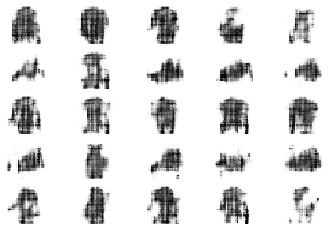

In [24]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()
 
# load model
model = load_model('cgan_generator.h5', compile= False)
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 5)

Running the example loads the saved conditional GAN model and uses it to generate 100 items of clothing.

The clothing is organized in columns. From left to right, they are “t-shirt“, ‘trouser‘, ‘pullover‘, ‘dress‘, ‘coat‘, ‘sandal‘, ‘shirt‘, ‘sneaker‘, ‘bag‘, and ‘ankle boot‘.

We can see not only are the randomly generated items of clothing plausible, but they also match their expected category.